<a href="https://colab.research.google.com/github/tkhabia/rust_object_detection_api/blob/master/rust_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')


TensorFlow 1.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk tree
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings tree
0 upgraded, 10 newly installed, 0 to remove and 29 not upgraded.
Need to get 1,859 kB of archives.
After this operation, 7,791 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/ma

In [3]:
%cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [4]:
%cd tensorflow/

/content/gdrive/My Drive/tensorflow


In [5]:
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.


/content/gdrive/My Drive/tensorflow/models/research


In [6]:
import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/tensorflow/models/research/:/content/gdrive/My Drive/tensorflow/models/research/slim'
print (os.environ['PYTHONPATH'])

/tensorflow-1.15.2/python3.6:/env/python:/content/gdrive/My Drive/tensorflow/models/research/:/content/gdrive/My Drive/tensorflow/models/research/slim


In [7]:
!python setup.py build
!python setup.py install

running build
running build_py
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/mean_stddev_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/model_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/multiscale_anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/calibration_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/optimizer_pb2.py -> build/l

In [0]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict
import pathlib
from google.colab import files
import six.moves.urllib as urllib
import sys
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [9]:
!python object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

In [0]:
#adjusted from: https://github.com/datitran/raccoon_dataset
from object_detection.utils import dataset_util


#change this to the base directory where your data/ is 

data_base_url = '/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/annotations/'
output_p  = '/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training/'
img_path = '/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/'
#location of images

def class_text_to_int(row_label):
  if row_label == 'rust':
    return 1
  else:
    None

def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
	with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
	  encoded_jpg = fid.read()
	encoded_jpg_io = io.BytesIO(encoded_jpg)
	image = Image.open(encoded_jpg_io)
	width, height = image.size
	filename = group.filename.encode('utf8')
	image_format = b'jpg'
	xmins = []
	xmaxs = []
	ymins = []
	ymaxs = []
	classes_text = []
	classes = []

	for index, row in group.object.iterrows():
		xmins.append(row['xmin'] / width)
		xmaxs.append(row['xmax'] / width)
		ymins.append(row['ymin'] / height)
		ymaxs.append(row['ymax'] / height)
		classes_text.append(row['class'].encode('utf8'))
		classes.append(class_text_to_int(row['class']))

	tf_example = tf.train.Example(features=tf.train.Features(feature={
		'image/height': dataset_util.int64_feature(height),
		'image/width': dataset_util.int64_feature(width),
		'image/filename': dataset_util.bytes_feature(filename),
		'image/source_id': dataset_util.bytes_feature(filename),
		'image/encoded': dataset_util.bytes_feature(encoded_jpg),
		'image/format': dataset_util.bytes_feature(image_format),
		'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
		'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
		'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
		'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
		'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
		'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
	return tf_example
#creates tfrecord for both csv's
for csv in ['train', 'test']:
  writer = tf.io.TFRecordWriter(output_p + csv + '.record')
  path = os.path.join(img_path , csv)
  examples = pd.read_csv(data_base_url + csv + '_labels' + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(output_p + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(output_path))


Successfully created the TFRecords: /content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training/train.record
Successfully created the TFRecords: /content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training/test.record


In [0]:
%%writefile object_detection/rust_object_detection/training/pipeline.config
model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: "faster_rcnn_inception_v2"
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        height_stride: 16
        width_stride: 16
        scales: 0.25
        scales: 0.5
        scales: 1.0
        scales: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 1.0
        aspect_ratios: 2.0
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.00999999977648
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.699999988079
    first_stage_max_proposals: 100
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
        use_dropout: false
        dropout_keep_probability: 1.0
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.300000011921
        iou_threshold: 0.600000023842
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}
train_config {
  batch_size: 12
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_vertical_flip {
    }
  }

  optimizer {
    momentum_optimizer {
      learning_rate {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 20000
            learning_rate: 1.99999994948e-05
          }
          schedule {
            step: 30000
            learning_rate: 1.99999999495e-06
          }
        }
      }
      momentum_optimizer_value: 0.899999976158
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  num_steps: 30000
}
train_input_reader {
  label_map_path: "/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/annotations/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training/train.record"
  }
}
eval_config {
  num_examples: 5
  max_evals: 10
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/annotations/label_map.pbtxt"
  shuffle: false
  num_readers: 1
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training/test.record"
  }
}

Overwriting object_detection/rust_object_detection/training/pipeline.config


In [0]:
!unzip -o ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = "/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training/"
get_ipython().system_raw(
    'tensorboard --logdir {} --port 8000 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8000 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
!python3 object_detection/model_main.py \
    --pipeline_config_path=/content/gdrive/My\ Drive/tensorflow/models/research/object_detection/rust_object_detection/training/pipeline.config \
    --model_dir=/content/gdrive/My\ Drive/tensorflow/models/research/object_detection/rust_object_detection/training/

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0511 11:44:55.637126 140231783020416 module_wrapper.py:139] From /content/gdrive/My Drive/tensorflow/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0511 11:44:55.641737 140231783020416 module_wrapper.py:139] From /content/gdrive/My Drive/tensorflow/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0511 11:44:55.641906 140231783020416 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0511 11:44:55.642042 14023178302

In [0]:
output_directory = '/content/gdrive/My\ Drive/tensorflow/models/research/object_detection/rust_object_detection/output_model'

lst = os.listdir('/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training')
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join('/content/gdrive/My\ Drive/tensorflow/models/research/object_detection/rust_object_detection/training', last_model)
# print (last_model_path)
!echo {last_model_path}

/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/training/model.ckpt-30000


In [10]:
!python /content/gdrive/My\ Drive/tensorflow/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/gdrive/My\ Drive/tensorflow/models/research/object_detection/rust_object_detection/training/pipeline.config \
    --output_directory=/content \
    --trained_checkpoint_prefix=/content/gdrive/My\ Drive/tensorflow/models/research/object_detection/rust_object_detection/training/model.ckpt-30000

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0512 10:57:59.853558 139871182419840 module_wrapper.py:139] From /content/gdrive/My Drive/tensorflow/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0512 10:58:00.721539 139871182419840 module_wrapper.py:139] From /content/gdrive/My Drive/tensorflow/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0512 10:58:00.722018 139871182419840 module_wrapper.py:139] From /content/gdrive/My Drive/tensorflow/models/research/object_detection/exporter.py:121: 

In [0]:


### Model preparation variable
MODEL_NAME = '/content'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = '/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/annotations/label_map.pbtxt'
NUM_CLASSES = 1 #remember number of objects you are training? cool.

### Load a (frozen) Tensorflow model into memory.
def load_model(path):
    with tf.gfile.GFile(path, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
    return graph
detection_graph = load_model(PATH_TO_FROZEN_GRAPH)
# with detection_graph.as_default():
#     od_graph_def = tf.GraphDef()
#     with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
#         serialized_graph = fid.read()
#         od_graph_def.ParseFromString(serialized_graph)
#         tf.import_graph_def(od_graph_def, name='')

In [13]:
tf.gfile = tf.io.gfile
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




In [22]:
import pathlib
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/train')
TEST_IMAGE_PATHS = list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg"))[15:20]

# for image_path in TEST_IMAGE_PATHS:
#   show_inference(detection_model, image_path)
# print ()
TEST_IMAGE_PATHS

[PosixPath('/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/train/21.jpg'),
 PosixPath('/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/train/12.jpg'),
 PosixPath('/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/train/16.jpg'),
 PosixPath('/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/train/20.jpg'),
 PosixPath('/content/gdrive/My Drive/tensorflow/models/research/object_detection/rust_object_detection/train/18.jpg')]

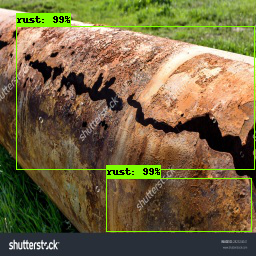

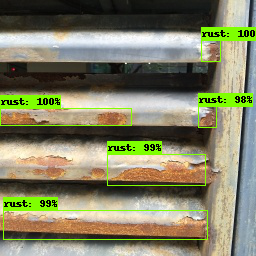

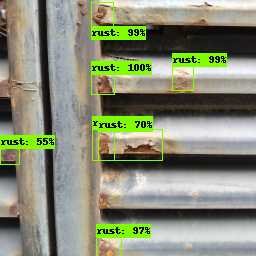

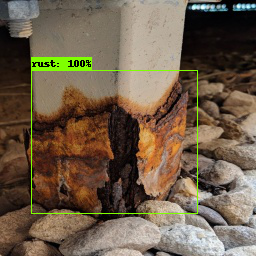

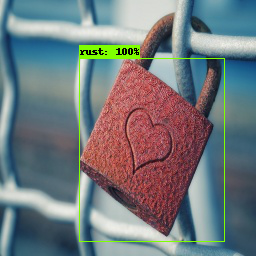

In [23]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1)
  display(Image.fromarray(image_np))
